Siddharth Kadam : **202318015**

<h1>Tasks</h1>

#1. Setup and Data Preparation
● Install and configure PySpark in your environment.<br>
● Initialize a Spark session and load the Online News Popularity dataset into a PySpark DataFrame.<br>
● Familiarize yourself with the dataset's structure and types of variables available.

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=754f94513852b2bf57dfa3beb2f0fa8149e0daa03df492015229b6f33a0cb4f2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Online News Popularity Prediction") \
    .getOrCreate()

In [4]:
# Load dataset into PySpark DataFrame
df = spark.read.csv("/content/OnlineNewsPopularity.csv", header=True, inferSchema=True)

In [ ]:
# Print DataFrame schema
df.printSchema()



In [6]:
# Display the first few rows of the DataFrame
df.show(5)

+--------------------+----------+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+-

In [7]:
# Display summary statistics of numerical columns
df.describe().show()

+-------+--------------------+-----------------+------------------+------------------+-------------------+-------------------+-------------------------+------------------+------------------+------------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------------+---------------------

#2. Data Preprocessing<br>
● Perform data cleaning, including dealing with missing values and any irrelevant features.<br>
● Since the dataset contains URL data as non-predictive, ensure this is excluded from your analysis.<br>
● Convert the dataset's target variable (shares) into a binary outcome for classification (popular vs. not
popular) based on a threshold you define (e.g., median value).

In [14]:
# Deal with missing values
df = df.dropna()

In [15]:
# Convert the target variable (shares) into binary outcome
median_shares = df.approxQuantile(" shares", [0.5], 0.01)[0]
df = df.withColumn("popularity", (df[" shares"] >= median_shares).cast("integer"))

In [16]:
# Drop irrelevant features such as URL data
df = df.drop("url")

#3. Exploratory Data Analysis (EDA)<br>
● Conduct EDA to understand the characteristics of popular and non-popular articles.<br>
● Analyze the distribution of key features and their impact on news popularity.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Analyze characteristics of popular and non-popular articles
df.groupBy("popularity").count().show()

+----------+-----+
|popularity|count|
+----------+-----+
|         1| 7443|
|         0| 6292|
+----------+-----+



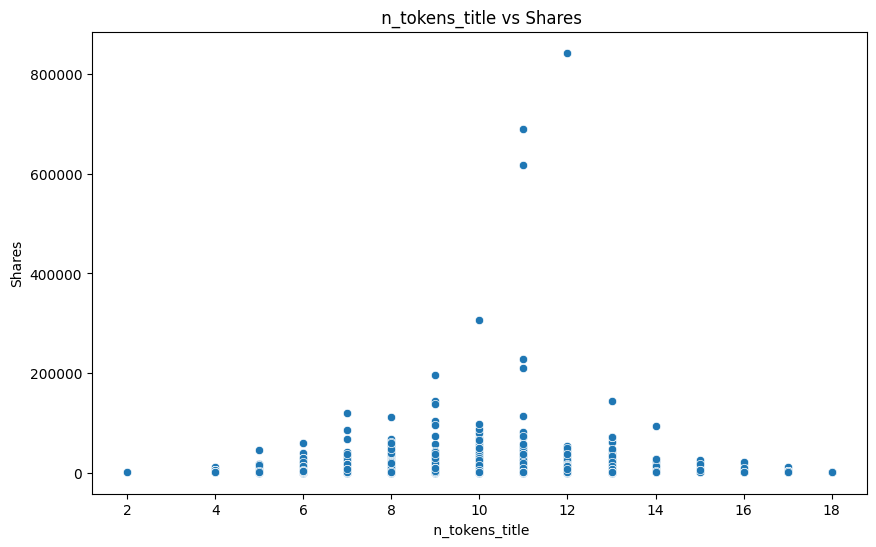

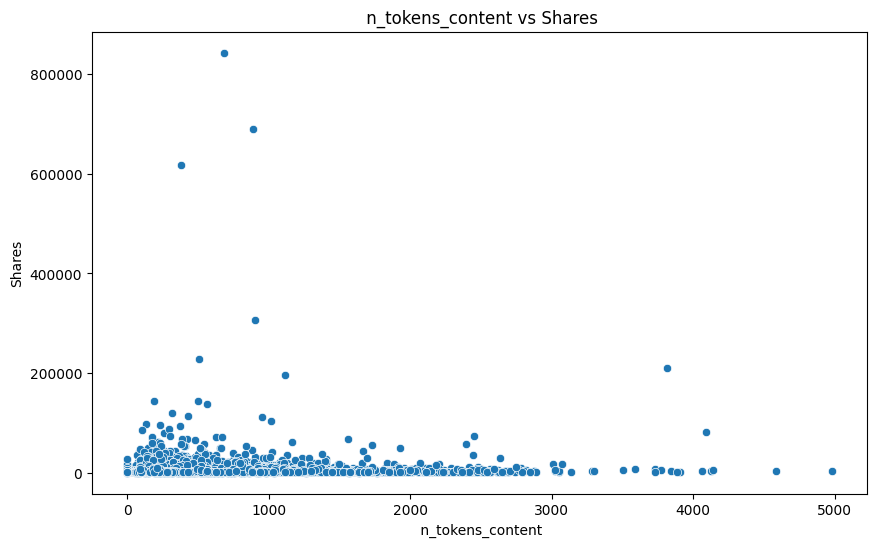

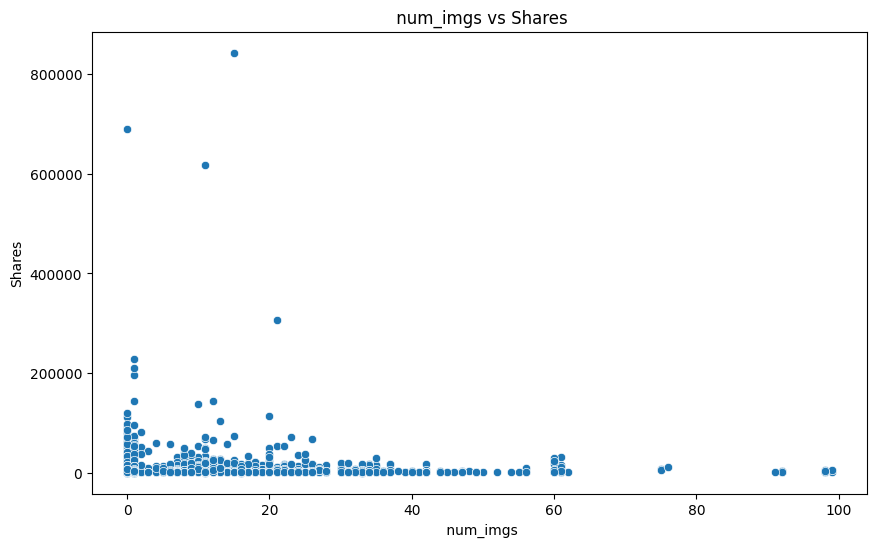

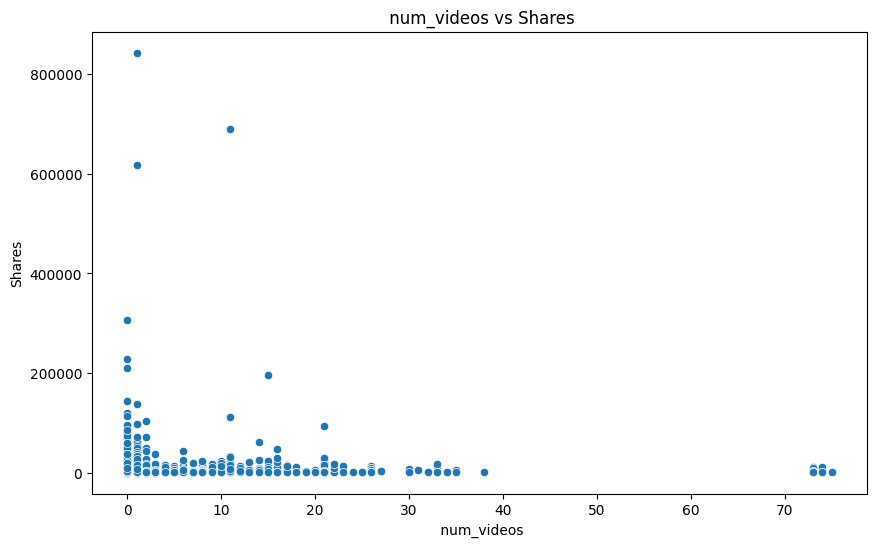

In [13]:
# Relationship between shares and other numerical features
numeric_features = [" n_tokens_title", " n_tokens_content", " num_imgs", " num_videos"]

for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df.toPandas(), x=feature, y=" shares")
    plt.title(f"{feature} vs Shares")
    plt.xlabel(feature)
    plt.ylabel("Shares")
    plt.show()

#4. Feature Engineering<br>
● Create new features that could potentially enhance model performance, such as article length
categories, weekday of publication, etc.<br>
● Use VectorAssembler to combine all feature columns into a single vector column.

In [17]:
# Create new features
# Example: Article length categories
from pyspark.ml.feature import Bucketizer

bucketizer = Bucketizer(splits=[0, 500, 1000, float('inf')], inputCol=" n_tokens_content", outputCol="article_length_cat")
df = bucketizer.transform(df)
df

DataFrame[ timedelta: double,  n_tokens_title: double,  n_tokens_content: double,  n_unique_tokens: double,  n_non_stop_words: double,  n_non_stop_unique_tokens: double,  num_hrefs: double,  num_self_hrefs: double,  num_imgs: double,  num_videos: double,  average_token_length: double,  num_keywords: double,  data_channel_is_lifestyle: double,  data_channel_is_entertainment: double,  data_channel_is_bus: double,  data_channel_is_socmed: double,  data_channel_is_tech: double,  data_channel_is_world: double,  kw_min_min: double,  kw_max_min: double,  kw_avg_min: double,  kw_min_max: double,  kw_max_max: double,  kw_avg_max: double,  kw_min_avg: double,  kw_max_avg: double,  kw_avg_avg: double,  self_reference_min_shares: double,  self_reference_max_shares: double,  self_reference_avg_sharess: double,  weekday_is_monday: double,  weekday_is_tuesday: double,  weekday_is_wednesday: double,  weekday_is_thursday: double,  weekday_is_friday: double,  weekday_is_saturday: double,  weekday_is_sun

#5. Model Building<br>
● Split the dataset into training and testing sets (80:20 ratio).<br>
● Train a classification model (e.g., Logistic Regression, Decision Tree, or Random Forest) to predict
article popularity.<br>
● Optionally, explore other algorithms and compare their performances.

I am

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Confusion Matrix
from pyspark.mllib.evaluation import MulticlassMetrics

In [25]:
# Split the dataset into training and testing sets (80:20 )
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
# Define features
feature_cols = df.columns
feature_cols.remove(" shares")  # Removing the target variable
feature_cols.remove("popularity")  # Removing the derived binary outcome
feature_cols.remove(" n_tokens_content")  # Removing the original feature after bucketing


# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Evaluate model performance
evaluator = BinaryClassificationEvaluator(labelCol="popularity", metricName="areaUnderROC")


In [26]:
def evaluate_model(predictions):
    evaluator_multi = MulticlassClassificationEvaluator(labelCol="popularity", metricName="f1")
    accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
    precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
    recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
    f1_score = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1_score)


##LogisticRegression

In [24]:
# LogisticRegression
lr = LogisticRegression(labelCol="popularity", featuresCol="features")
lr_pipeline = Pipeline(stages=[assembler, lr])
lr_model = lr_pipeline.fit(train_data)

Evaluation

In [27]:
# Evaluate Logistic Regression model
lr_predictions = lr_model.transform(test_data)
lr_auc = evaluator.evaluate(lr_predictions)

# Print AUC scores
print("Logistic Regression AUC: ", lr_auc)



Logistic Regression AUC:  0.6969469104328248


In [28]:
evaluate_model(lr_predictions)

Accuracy:  0.6500941619585687
Precision:  0.6487616290064753
Recall:  0.6500941619585687
F1 Score:  0.6491681571782936


##Decision Tree model

In [30]:
dt = DecisionTreeClassifier(labelCol="popularity", featuresCol="features")
dt_pipeline = Pipeline(stages=[assembler, dt])
dt_model = dt_pipeline.fit(train_data)

Evaluation

In [31]:
# Evaluate Decision Tree model
dt_predictions = dt_model.transform(test_data)
dt_auc = evaluator.evaluate(dt_predictions)
# Print AUC scores
print("Decision Tree AUC: ", dt_auc)



Decision Tree AUC:  0.5392961487688952


In [32]:
evaluate_model(dt_predictions)

Accuracy:  0.6463276836158192
Precision:  0.6440751275918691
Recall:  0.6463276836158192
F1 Score:  0.6441827439795085


##RandomForest model

In [33]:
rf = RandomForestClassifier(labelCol="popularity", featuresCol="features")
rf_pipeline = Pipeline(stages=[assembler, rf])
rf_model = rf_pipeline.fit(train_data)

Evaluation

In [34]:
# Evaluate Random Forest model
rf_predictions = rf_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_predictions)

In [35]:
evaluate_model(rf_predictions)

Accuracy:  0.6429378531073446
Precision:  0.6441813617230852
Recall:  0.6429378531073446
F1 Score:  0.6279948629190228
